In [1]:
import os
import subprocess
import torch
import re
os.chdir('../')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

from IPython.display import HTML as html_print
from research.utils import load_vocabulary, Tokenizer, Aligner, RelaxedTargetField, OneHotEncoder, bleu
from research.scorer import Scorer
from research.greedy_optimizer import GreedyOptimizer
from research.beam_optimizer import BeamOptimizer
from research.continuous_optimizer import ContinuousOptimizer

### Model loading

In [2]:
vocab = load_vocabulary()
tokenizer = Tokenizer()
scorer = Scorer()
one_hot_encoder = OneHotEncoder(vocab)

### Translation scoring

In [3]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
german_translation_from_google = 'Ich denke, dass maschinelle Übersetzung ein sehr interessantes Thema ist.'
score = scorer.score_texts(english_sentence, german_translation_from_google)
print('Translation scoring')
print('English sentence:', english_sentence)
print('Translation from google translate to score:', german_translation_from_google)
print('Log likehood of translation:', score[0])

Translation scoring
English sentence: I think, that machine translation is a very interesting subject.
Translation from google translate to score: Ich denke, dass maschinelle Übersetzung ein sehr interessantes Thema ist.
Log likehood of translation: -6.253188


### Predicting of next word in translation

In [4]:
unfinished_translation = 'Ich denke, dass maschinelle Übersetzung ein sehr'
english_tokens = tokenizer.tokenize(english_sentence)
german_tokens = tokenizer.tokenize(unfinished_translation)
next_word_probs = scorer.next_word_probabilities([english_tokens], [german_tokens])
val, ind = next_word_probs.topk(3)
print('English sentence:', english_sentence)
print('Unfinished translation:', unfinished_translation )
print('Top 3 next tokens: ', vocab.itos[ind[0,0].view(-1)], vocab.itos[ind[0,1].view(-1)], vocab.itos[ind[0,2].view(-1)])

English sentence: I think, that machine translation is a very interesting subject.
Unfinished translation: Ich denke, dass maschinelle Übersetzung ein sehr
Top 3 next tokens:  ▁interessante ▁interessant ▁Interessant


### Greedy optimization

In [5]:
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = GreedyOptimizer(english_sentence)
print('Optimizer initialized...')
german_tokens = optimizer.optimize()[:-1]
score = scorer.score_tokenized_texts([english_tokens], [german_tokens])[0]
print('English sentence:', english_sentence)
print('Translated tokens', ' '.join(german_tokens))
print(f'Log likehood of translation: {score:.2f}')

Optimizer initialized...
English sentence: I think, that machine translation is a very interesting subject.
Translated tokens ▁Ich ▁denke , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist .
Log likehood of translation: -5.41


### Beam search optimization

In [6]:
n_beams = 15
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I think, that machine translation is a very interesting subject.
Top 15 translations:
1. ▁Ich ▁denke , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -5.41]
2. ▁Ich ▁glaube , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -5.74]
3. ▁Ich ▁halte ▁die ▁ maschine lle ▁Übersetzung ▁für ▁ein ▁sehr ▁interessante s ▁Thema . [p = -5.77]
4. ▁Ich ▁denke , ▁dass ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.25]
5. ▁Ich ▁glaube , ▁dass ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.65]
6. ▁Ich ▁finde , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.70]
7. ▁Ich ▁denke , ▁die ▁ maschine lle ▁Übersetzung ▁ist ▁ein ▁sehr ▁interessante s ▁Thema . [p = -6.87]
8. ▁Meine s ▁Era chtens ▁ist ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema . [p = -7.14]
9. ▁Ich ▁denke , ▁da

### Entropy of conditional probabilities for each word in different translations

In [7]:
def plot_entropies(i):
    plt.title('Entropy for each word in different translations')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    trans = translations[i][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    words = list(range(probs.shape[0]))
    entropies = [entropy(probs[k, :]) for k in words]
    plt.scatter(words, entropies, label=f'Translation {i}')
    print(f'Translation {i}:\n{" | ".join(trans)}')
    print()
    plt.legend()

def plot_aligned_entropies(i, j):
    plt.title('Entropy for each word in different translations (aligned)')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    
    aligner = Aligner()
    trans_i = translations[i][:-1]
    trans_j = translations[j][:-1]
    aligned_i, aligned_j = aligner.align(trans_i, trans_j)
    
    logprobs_i = scorer.score_probabilities_for_each_word(english_tokens, trans_i)
    probs_i = np.exp(logprobs_i)
    logprobs_j = scorer.score_probabilities_for_each_word(english_tokens, trans_j)
    probs_j = np.exp(logprobs_j)

    words = np.arange(len(aligned_i))
    entropies_i = []
    k = 0
    for word in aligned_i:
        if word == '[PLACEHOLDER]':
            entropies_i += [-1.]
        else:
            entropies_i += [entropy(probs_i[k, :])]
            k += 1
    entropies_i = np.array(entropies_i)
    
    entropies_j = []
    k = 0
    for word in aligned_j:
        if word == '[PLACEHOLDER]':
            entropies_j += [-1.]
        else:
            entropies_j += [entropy(probs_j[k, :])]
            k += 1
    entropies_j = np.array(entropies_j)
    
    plt.scatter(words[entropies_i >= 0.], entropies_i[entropies_i >= 0.], label=f'Translation {i}')
    plt.scatter(words[entropies_j >= 0.], entropies_j[entropies_j >= 0.], label=f'Translation {j}')
    print(f'Translation {i}:\n{" | ".join(aligned_i)}')
    print(f'Translation {j}:\n{" | ".join(aligned_j)}')
    print()
    plt.legend()
    
def plot_maxs(i):
    plt.title('Max for each word in different translations')
    plt.xlabel('Word number')
    plt.ylabel('Max')
    trans = translations[i][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    words = list(range(probs.shape[0]))
    entropies = [np.max(probs[k, :]) for k in words]
    plt.scatter(words, entropies, label=f'Translation {i}')
    print(f'Translation {i}:\n{" | ".join(trans)}')
    print()
    plt.legend()
    
def other_candidates(trans_idx, pos, N = 4):
    trans = translations[trans_idx][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    other_good_choices = np.argsort(probs[pos])[:-6:-1]
    print('Best candidates on position', pos, ': ', ' '.join([vocab.itos[idx] for idx in other_good_choices]))
    print('Coresponding probabilities:', [probs[pos][idx] for idx in other_good_choices])    

#### Comparison of the best and the worst translation

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .

Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



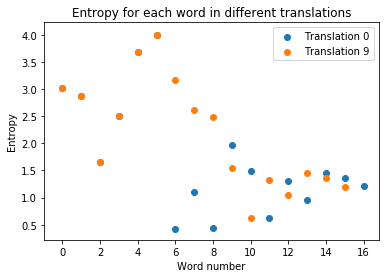

In [8]:
for i in [0, 9]:
    plot_entropies(i)
plt.show()

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .

Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



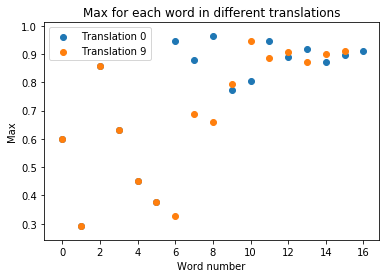

In [9]:
for i in [0, 9]:
    plot_maxs(i)
plt.show()

Entropia z jakiegoś powodu jest bardzo słabą miarą (chyba, że bug). Entropia dla pozycji 0 w zdaniu 9 niewiele różni się od entropi na pozycji 1 w zdaniu 9, a te rozkłady są zupełnie różne (na pozycji 0 mamy tylko 1 prawdopodobną wartość, a na pozycji 1 aż 4). Przykład poniżej:

#### Entropies of alligned sentences

Best vs worst translation:

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | [PLACEHOLDER] | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



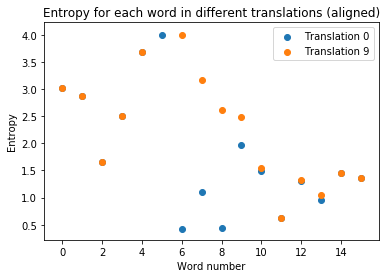

In [11]:
plot_aligned_entropies(0, 9)

Beam-10 vs Greedy translation:

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 3:
▁Ich | ▁denke | , | ▁dass | [PLACEHOLDER] | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



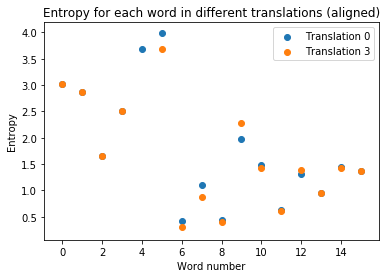

In [12]:
plot_aligned_entropies(0, 3)

Similar translations:

Translation 3:
▁Ich | ▁denke | , | ▁dass | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 4:
▁Ich | ▁glaube | , | ▁dass | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



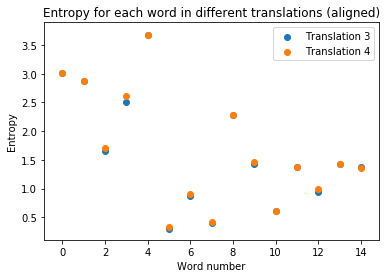

In [13]:
plot_aligned_entropies(3, 4)

In [14]:
other_candidates(9, 0)

Best candidates on position 0 :  ▁Ich ▁Das ▁Die ▁Meiner ▁Meine
Coresponding probabilities: [0.5988918, 0.060954917, 0.036728892, 0.024799734, 0.024179423]


In [152]:
other_candidates(9, 1)

Best candidates on position 1 :  ▁denke ▁glaube ▁halte ▁finde ▁bin
Coresponding probabilities: [0.29839528, 0.25234625, 0.13621552, 0.10573821, 0.043860655]


Zwróćmy też uwagę na niejednoznaczność tokenów: w miejscu, w którym wybieramy token _ prawdopodobieństwo jest małe, oraz entropia duża. Wynika to najprawdopodobniej z tego, że zamiast wybrać token _ , możemy wybrać cały token _ machinelle

### Other probable candidates

In [154]:
other_candidates(3, 1)

Best candidates on position 1 :  ▁denke ▁glaube ▁halte ▁finde ▁bin
Coresponding probabilities: [0.29839528, 0.25234625, 0.13621552, 0.10573821, 0.043860655]


In [153]:
other_candidates(3, 4)

Best candidates on position 4 :  ▁die ▁ ▁das ▁Maschinen ▁eine
Coresponding probabilities: [0.4021218, 0.112477794, 0.079811126, 0.05037697, 0.028617628]


In [155]:
other_candidates(3, 5)

Best candidates on position 5 :  ▁ ▁Übersetzung ▁Maschinen ▁technische ▁Maschinenbau
Coresponding probabilities: [0.4092544, 0.16365328, 0.06526854, 0.013711214, 0.0103740515]


In [156]:
other_candidates(3, 12)

Best candidates on position 12 :  . ▁Thema ▁Themen ▁Gegenstand ▁Subjekt
Coresponding probabilities: [0.45098555, 0.357347, 0.021454206, 0.005650598, 0.0052555017]


In [9]:
other_candidates(0, 5)

Best candidates on position 5 :  lle llen ll ller elle
Coresponding probabilities: [0.89663786, 0.026253838, 0.022556117, 0.012132816, 0.004152786]


In [15]:
other_candidates(0, 0)

Best candidates on position 0 :  ▁Ich ▁Das ▁Die ▁Meiner ▁Meine
Coresponding probabilities: [0.5988918, 0.060954917, 0.036728892, 0.024799734, 0.024179423]


### More difficult sentences:

In [3]:
n_beams = 30
english_sentence = 'Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.'
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.
Top 30 translations:
1. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁ihnen . [p = -11.66]
2. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁ihnen . [p = -11.69]
3. ▁Kinder ▁lieben ▁ihre ▁Eltern ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁sie . [p = -11.72]
4. ▁Kinder ▁beginnen , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁ihnen . [p = -11.73]
5. ▁Kinder ▁beginnen , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁ihnen . [p = -11.83]
6. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁liebe

In [4]:
n_beams = 1
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.
Top 1 translations:
1. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁sie ▁ihnen . [p = -11.85]
Sanity check: log likehood of the best translation = -11.85


In [7]:
n_beams = 30
english_sentence = "There is always something ridiculous about the emotions of people whom one has ceased to love."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: There is always something ridiculous about the emotions of people whom one has ceased to love.
Top 30 translations:
1. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -8.88]
2. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.00]
3. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.06]
4. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.08]
5. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁zu ▁lieben . [p = -9.32]
6. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Gefühl e ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.35]
7. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich

In [6]:
n_beams = 1
english_sentence = "There is always something ridiculous about the emotions of people whom one has ceased to love."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: There is always something ridiculous about the emotions of people whom one has ceased to love.
Top 1 translations:
1. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁nicht ▁mehr ▁lieben . [p = -9.60]
Sanity check: log likehood of the best translation = -9.60


In [3]:
n_beams = 10
english_sentence = "I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self.
Top 10 translations:
1. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.36]
2. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁er , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.37]
3. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der j en ige , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.54]
4. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et , ▁als ▁den , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.68]
5. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁er , ▁der ▁sei

In [8]:
n_beams = 1
english_sentence = "I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self.
Top 1 translations:
1. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der j en ige , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.54]
Sanity check: log likehood of the best translation = -9.54


### Continuous optimization

#### Uniform initialization

In [36]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
english_tok = tokenizer.tokenize(english_sentence)
optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize()
print(res)

Optimization starts...
Score at step  0 = tensor([24.4894], grad_fn=<NegBackward>) max grad component =  lr =  99.0
Score at step  1 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  59.4
Score at step  2 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  35.64
Score at step  3 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  21.384
Score at step  4 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  12.8304
Score at step  5 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  7.698239999999999
Score at step  6 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.618943999999999
Score at step  7 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.7713663999999993
Score at step  8 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0

Score at step  67 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.3544686900010173e-13
Score at step  68 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.126812140006103e-14
Score at step  69 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.876087284003662e-14
Score at step  70 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.925652370402197e-14
Score at step  71 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.7553914222413183e-14
Score at step  72 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.053234853344791e-14
Score at step  73 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.319409120068745e-15
Score at step  74 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.791645472041247e-1

Score at step  134 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.853116598174821e-28
Score at step  135 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.1118699589048926e-28
Score at step  136 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.671219753429356e-29
Score at step  137 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.0027318520576135e-29
Score at step  138 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.401639111234568e-29
Score at step  139 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.4409834667407408e-29
Score at step  140 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.645900800444445e-30
Score at step  141 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.187540480

Score at step  200 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.225569715739044e-43
Score at step  201 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.535341829443426e-43
Score at step  202 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.5212050976660558e-43
Score at step  203 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  9.127230585996333e-44
Score at step  204 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.476338351597799e-44
Score at step  205 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.2858030109586797e-44
Score at step  206 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.9714818065752077e-44
Score at step  207 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.182889083

Score at step  266 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  9.635356695934406e-58
Score at step  267 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.7812140175606435e-58
Score at step  268 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.468728410536386e-58
Score at step  269 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.0812370463218313e-58
Score at step  270 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.2487422277930988e-58
Score at step  271 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  7.492453366758592e-59
Score at step  272 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.495472020055155e-59
Score at step  273 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.697283212

Score at step  331 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.661837531322898e-72
Score at step  332 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.1971025187937385e-72
Score at step  333 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.318261511276243e-72
Score at step  334 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  7.909569067657458e-73
Score at step  335 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.7457414405944743e-73
Score at step  336 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.8474448643566843e-73
Score at step  337 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.7084669186140106e-73
Score at step  338 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.02508015

Score at step  397 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.349906202100137e-87
Score at step  398 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.009943721260082e-87
Score at step  399 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.0059662327560493e-87
Score at step  400 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.8035797396536294e-87
Score at step  401 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.0821478437921776e-87
Score at step  402 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.492887062753065e-88
Score at step  403 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.895732237651839e-88
Score at step  404 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.337439342

Score at step  463 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.9039876288198557e-101
Score at step  464 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.1423925772919134e-101
Score at step  465 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.8543554637514805e-102
Score at step  466 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.1126132782508884e-102
Score at step  467 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.467567966950533e-102
Score at step  468 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.4805407801703196e-102
Score at step  469 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.883244681021917e-103
Score at step  470 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.

#### Greedy initialization with one hot vectors

In [31]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = one_hot_encoder.encode(torch.tensor([[[vocab.stoi[tok] for tok in greedy_translation]]]).transpose(0, 2), v=1000.).squeeze().transpose(0, 1)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init)
print(res)

Optimization starts...
Score at step  0 = tensor([0.4511], grad_fn=<NegBackward>) max grad component =  lr =  99.0
Score at step  1 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  59.4
Score at step  2 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  35.64
Score at step  3 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  21.384
Score at step  4 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  12.8304
Score at step  5 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.698239999999999
Score at step  6 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.618943999999999
Score at step  7 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.7713663999999993
Score at step  8 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.6628198399999996
S

Score at step  70 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.925652370402197e-14
Score at step  71 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.7553914222413183e-14
Score at step  72 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.053234853344791e-14
Score at step  73 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.319409120068745e-15
Score at step  74 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.791645472041247e-15
Score at step  75 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.2749872832247482e-15
Score at step  76 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.3649923699348489e-15
Score at step  77 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.189954219609093e-16
Score at step  78 = tensor([0

Score at step  138 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.401639111234568e-29
Score at step  139 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.4409834667407408e-29
Score at step  140 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.645900800444445e-30
Score at step  141 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.187540480266667e-30
Score at step  142 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.11252428816e-30
Score at step  143 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.867514572896e-30
Score at step  144 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.1205087437376e-30
Score at step  145 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.723052462425599e-31
Score at step  146 = tensor([0.4

Score at step  206 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.9714818065752077e-44
Score at step  207 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.1828890839451247e-44
Score at step  208 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.097334503670747e-45
Score at step  209 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.258400702202448e-45
Score at step  210 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.5550404213214687e-45
Score at step  211 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.5330242527928812e-45
Score at step  212 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  9.198145516757287e-46
Score at step  213 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.518887310054372e-46
Score at step  214 =

Score at step  274 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.6183699272198558e-59
Score at step  275 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  9.710219563319135e-60
Score at step  276 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.826131737991481e-60
Score at step  277 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.4956790427948885e-60
Score at step  278 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.097407425676933e-60
Score at step  279 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.2584444554061598e-60
Score at step  280 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.550666732436959e-61
Score at step  281 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.5304000394621755e-61
Score at step  282 =

Score at step  342 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.3285038759142543e-74
Score at step  343 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.971023255485526e-75
Score at step  344 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.782613953291315e-75
Score at step  345 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.869568371974789e-75
Score at step  346 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.7217410231848733e-75
Score at step  347 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.033044613910924e-75
Score at step  348 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.198267683465544e-76
Score at step  349 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.718960610079326e-76
Score at step  350 = t

Score at step  410 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.090555699679305e-89
Score at step  411 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.54333419807583e-90
Score at step  412 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.926000518845498e-90
Score at step  413 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.3556003113072986e-90
Score at step  414 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.4133601867843791e-90
Score at step  415 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.480161120706275e-91
Score at step  416 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.088096672423765e-91
Score at step  417 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.0528580034542586e-91
Score at step  418 = t

Score at step  478 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.952263938895583e-105
Score at step  479 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.37135836333735e-105
Score at step  480 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.2228150180024095e-105
Score at step  481 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.9336890108014457e-105
Score at step  482 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.1602134064808673e-105
Score at step  483 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.961280438885203e-106
Score at step  484 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.1767682633311215e-106
Score at step  485 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.5060609579986726e-106
Score at ste

In [32]:
print('Greedy translation:', greedy_translation)
print('Continuous translation:', res)
print('Score of greedy translation = ' , scorer.score_tokenized_texts([english_tok], [greedy_translation]))
print('Score of continuous translation = ', scorer.score_tokenized_texts([english_tok], [res]))

Greedy translation: ['▁Ich', '▁denke', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist', '.']
Continuous translation: ['▁Ich', '▁denke', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist', '.']
Score of greedy translation =  tensor([-0.4511])
Score of continuous translation =  tensor([-0.4511])


#### Greedy initialization with probabilities

In [34]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:15, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init)
print(res)

Optimization starts...
Score at step  0 = tensor([1.8099], grad_fn=<NegBackward>) max grad component =  lr =  99.0
Score at step  1 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.) lr =  98.01
Score at step  2 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  58.806
Score at step  3 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  35.2836
Score at step  4 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  21.17016
Score at step  5 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  12.702096
Score at step  6 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  7.621257599999999
Score at step  7 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.572754559999999
Score at step  8 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.743

Score at step  68 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.3409240031010065e-13
Score at step  69 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.045544018606039e-14
Score at step  70 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.827326411163623e-14
Score at step  71 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.8963958466981735e-14
Score at step  72 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.737837508018904e-14
Score at step  73 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.0427025048113424e-14
Score at step  74 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.256215028868054e-15
Score at step  75 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.7537290173208325e-15
Scor

Score at step  134 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.0576423869884536e-28
Score at step  135 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.834585432193072e-28
Score at step  136 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.100751259315843e-28
Score at step  137 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.604507555895059e-29
Score at step  138 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.962704533537035e-29
Score at step  139 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.377622720122221e-29
Score at step  140 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.4265736320733325e-29
Score at step  141 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.559441792439995e-3

Score at step  201 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.183314018581651e-43
Score at step  202 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.5099884111489904e-43
Score at step  203 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.5059930466893943e-43
Score at step  204 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  9.035958280136365e-44
Score at step  205 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  5.421574968081819e-44
Score at step  206 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.2529449808490915e-44
Score at step  207 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.9517669885094548e-44
Score at step  208 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.1710601931056727

Score at step  267 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  9.539003128975051e-58
Score at step  268 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  5.72340187738503e-58
Score at step  269 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.434041126431018e-58
Score at step  270 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.060424675858611e-58
Score at step  271 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.2362548055151665e-58
Score at step  272 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  7.417528833090999e-59
Score at step  273 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.450517299854599e-59
Score at step  274 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.670310379912759e-59


Score at step  334 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.305078896163479e-72
Score at step  335 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  7.830473376980874e-73
Score at step  336 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.698284026188524e-73
Score at step  337 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.8189704157131146e-73
Score at step  338 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.6913822494278687e-73
Score at step  339 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.0148293496567212e-73
Score at step  340 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.088976097940327e-74
Score at step  341 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.653385658764196e-

Score at step  401 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.7855439422570933e-87
Score at step  402 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.071326365354256e-87
Score at step  403 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.427958192125536e-88
Score at step  404 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.8567749152753214e-88
Score at step  405 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.3140649491651927e-88
Score at step  406 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.3884389694991155e-88
Score at step  407 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.330633816994693e-89
Score at step  408 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.998380290196815e

Score at step  467 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.0714871454683796e-102
Score at step  468 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.4428922872810275e-102
Score at step  469 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.4657353723686165e-102
Score at step  470 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.794412234211698e-103
Score at step  471 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  5.276647340527019e-103
Score at step  472 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.1659884043162114e-103
Score at step  473 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.8995930425897267e-103
Score at step  474 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.13975582

In [35]:
print('Greedy translation:', greedy_translation)
print('Continuous translation:', res)
print('Score of greedy translation = ' , scorer.score_tokenized_texts([english_tok], [greedy_translation]))
print('Score of continuous translation = ', scorer.score_tokenized_texts([english_tok], [res]))

Greedy translation: ['▁Ich', '▁denke', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist', '.']
Continuous translation: ['▁Ich', '▁halte', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist']
Score of greedy translation =  tensor([-0.4511])
Score of continuous translation =  tensor([-1.6082])


#### Sentence from test set

In [3]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:-1, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init, method='multiplication', verbose=True)
print(res)

Optimization starts...
Step 0 , loss score =  tensor([2.3881], grad_fn=<NegBackward>) max grad component =  lr =  100
	 cscore =  tensor([2.3881], grad_fn=<NegBackward>)
	dscore =  tensor([0.5355])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁würde , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 1 , loss score =  tensor([1.9038], grad_fn=<NegBackward>) max grad component = 0.0 lr =  100
	 cscore =  tensor([1.9038], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 2 , loss score =  tensor([1.6958], grad_fn=<NegBackward>) max grad component = 0.0 lr =  100
	 cscore =  tensor([1.6958], grad_fn=<NegBackward>)
	dscore =  tensor([0.5412])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁will , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁en

Step 24 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  0.01220703125
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 25 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  0.006103515625
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 26 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  0.0030517578125
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁d

	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 47 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  1.4551915228366852e-09
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 48 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  7.275957614183426e-10
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 49 , loss score =  

In [4]:
print('Greedy translation:', ' '.join(greedy_translation))
print('Continuous translation:', ' '.join(res))
print('Score of greedy translation = ' , -scorer.score_tokenized_texts([english_tok], [greedy_translation], method='multiplication', normalize=True))
print('Score of continuous translation = ', -scorer.score_tokenized_texts([english_tok], [res], method='multiplication', normalize=True))

Greedy translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁würde , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "
Continuous translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "
Score of greedy translation =  tensor([0.5355])
Score of continuous translation =  tensor([0.5352])


In [55]:
print('BLEU of greedy: 11.06')
print('BLEU of continuous: 9.67')
print('(measured by multi-bleu.perl script)')

BLEU of greedy: 11.06
BLEU of continuous: 9.67
(measured by multi-bleu.perl script)


In [60]:
n_beams = 10
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimization starts...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tok], [translations[0][:-1]])[0]
print(f'Sanity check: score of the best translation = {score:.2f}')

Optimization starts...
English sentence: But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."
Top 10 translations:
1. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁indem ▁er ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . " [p = -20.19]
2. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁wenn ▁er ▁sagte : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . " [p = -20.32]
3. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁wenn ▁er ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . " [p = -20.34]
4. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁indem ▁er ▁sagt : ▁" Es ▁geht ▁ihm ▁endlich ▁gut . " [p = -20.59]
5. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jem

In [61]:
print('BLEU of beam: 12.98')

BLEU of beam: 12.98


In [ ]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:-1, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init, method='cross_entropy', verbose=True)
print(res)

### Continuous with cross entropy

In [3]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:-1, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init, method='multiplication')
print(res)

KeyboardInterrupt: 

In [5]:
print('Greedy translation:', ' '.join(greedy_translation))
print('Continuous translation:', ' '.join(res))
print('Score of greedy translation = ' , scorer.score_tokenized_texts([english_tok], [greedy_translation]))
print('Score of continuous translation = ', scorer.score_tokenized_texts([english_tok], [res]))

Greedy translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁würde , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "
Continuous translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagte , ▁er ▁könne ▁nicht en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagte : ▁„ Es ▁ging ▁ihm ▁endlich ▁gut . "
Score of greedy translation =  tensor([-0.5355])
Score of continuous translation =  tensor([-1.0102])


In [6]:
print('BLEU of continuous translation with cross entropy: 13.46')

BLEU of continuous translation with cross entropy: 13.46


#### Continuous optimization with cross entropy - uniform initialization

In [11]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(method='multiplication', verbose=True)
print(res)

Optimization starts...
0
Step 0 , loss score =  tensor([24.9637], grad_fn=<NegBackward>) max grad component =  lr =  50
	 cscore =  tensor([24.9637], grad_fn=<NegBackward>)


AssertionError: Dataset cannot contain Special Tokens

In [64]:
def plot_aligned_entropies(trans_i, trans_j):
    plt.title('Entropy for each word in different translations (aligned)')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    
    aligner = Aligner()
    aligned_i, aligned_j = aligner.align(trans_i, trans_j)
    
    logprobs_i = scorer.score_probabilities_for_each_word(english_tok, trans_i)
    probs_i = np.exp(logprobs_i)
    logprobs_j = scorer.score_probabilities_for_each_word(english_tok, trans_j)
    probs_j = np.exp(logprobs_j)

    words = np.arange(len(aligned_i))
    entropies_i = []
    k = 0
    for word in aligned_i:
        if word == '[PLACEHOLDER]':
            entropies_i += [-1.]
        else:
            entropies_i += [entropy(probs_i[k, :])]
            k += 1
    entropies_i = np.array(entropies_i)
    
    entropies_j = []
    k = 0
    for word in aligned_j:
        if word == '[PLACEHOLDER]':
            entropies_j += [-1.]
        else:
            entropies_j += [entropy(probs_j[k, :])]
            k += 1
    entropies_j = np.array(entropies_j)
    
    plt.scatter(words[entropies_i >= 0.], entropies_i[entropies_i >= 0.], label=f'Translation 1')
    plt.scatter(words[entropies_j >= 0.], entropies_j[entropies_j >= 0.], label=f'Translation 2')
    print(f'Translation 1:\n{" | ".join(aligned_i)}')
    print(f'Translation 2:\n{" | ".join(aligned_j)}')
    print()
    plt.legend()

Translation 1:
▁Aber | ▁der | ▁Bruder | ▁des | ▁Opfer | s | ▁sagt | , | ▁er | ▁könne | ▁nicht | ▁an | ▁jemand | en | ▁denken | , | ▁der | ▁ihm | ▁we | h | ▁tun | ▁würde | , | ▁indem | ▁er | ▁sagt | : | ▁" | Es | ▁ging | ▁ihm | ▁endlich | ▁gut | . | "
Translation 2:
▁Aber | ▁der | ▁Bruder | ▁des | ▁Opfer | s | ▁sagt | , | ▁er | ▁könne | [PLACEHOLDER] | [PLACEHOLDER] | ▁niemand | en | ▁denken | , | ▁der | [PLACEHOLDER] | ▁ihn | ▁verletz | en | ▁würde | , | [PLACEHOLDER] | ▁und | ▁sagt | : | ▁" | Es | ▁ging | ▁ihm | ▁endlich | ▁gut | . | "



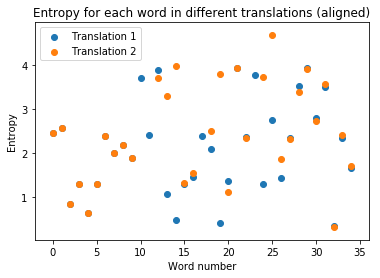

In [66]:
plot_aligned_entropies(translations[0][:-1], greedy_translation, )

### Continuous with multiplication - more examples

In [3]:
WMT_DIR = '/home/pma/wmt/'
german_path = WMT_DIR + 'test.de'
english_path = WMT_DIR + 'test.en'

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def load_test_data(path):
    with open(path) as f:
        return [tokenizer.detokenize(line.split()) for line in f.readlines()]

def load_reference_data(path):
    with open(path) as f:
        return [line.strip() for line in f.readlines()]
    
def perform_tests(k=50, initialization='greedy', beamsize=15):
    aligner = Aligner()
    english_sentences = load_test_data(english_path)
    references = load_reference_data(german_path)
    for english_sentence, reference in zip(english_sentences[:k], references):
        english_tok = tokenizer.tokenize(english_sentence)
        if initialization == 'greedy':
            greedy_optimizer = GreedyOptimizer(english_sentence)
            greedy_translation = greedy_optimizer.optimize()[:-1]
        else:
            greedy_optimizer = BeamOptimizer(english_sentence, beamsize)
            greedy_translation = greedy_optimizer.optimize()[0][0][:-1]
        
        greedy_score = -scorer.score_tokenized_texts([english_tok], [greedy_translation], method='multiplication', normalize=True)
        gbleu = bleu(reference, ' '.join(greedy_translation))

        greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
        greedy_init = torch.tensor(greedy_init[:-1, :].T)
        continuous_optimizer = ContinuousOptimizer(english_sentence)
        continuous_translation, cscore = continuous_optimizer.optimize(init=greedy_init, method='multiplication', with_score=True, start_lr=100)
        dscore = -scorer.score_tokenized_texts([english_tok], [continuous_translation], method='multiplication', normalize=True)
        cbleu = bleu(reference, ' '.join(continuous_translation))

        aligned_greedy, aligned_continuous = aligner.align(greedy_translation, continuous_translation)
        
        colored_continuous = [cstr(cword, color='black') if gword == cword else cstr(cword, color='green') 
            for gword, cword in zip(aligned_greedy, aligned_continuous)]
        colored_continuous.append(cstr(f'[ cscore={cscore.item()}, dscore={dscore.item()}, bleu={cbleu} ]', color='black'))
        
        display(html_print(cstr(' '.join(aligned_greedy) + f'[ dscore={greedy_score.item()}, bleu={gbleu} ]', color='black')))
        display(html_print(' '.join(colored_continuous)))
        display(html_print('<br>'))

In [ ]:
perform_tests(k=100, initialization='greedy')

In [ ]:
perform_tests(k=50, initialization='beam', beamsize=5)